In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plorts
from common import *
import matplotlib

plt.style.use(['plorts', 'plorts-print', './buffer-workshop.mplstyle'])
width = 7.141/2
matplotlib.rcParams['figure.figsize'] = (width, width*1/3)

In [3]:
cubic = pd.read_sql("""
select * from postcard_traces
inner join experiments on experiments.id = experiment_id
where note in ('postcard', 'postcard-ecn', 'bbr2')
  and algorithm in ('cubic', 'reno', 'bbr', 'bbr2', 'scalable', 'vegas')
  and max_queue_depth_cells = 20000
  and action = 'drop'
  and num_flows = 1
""", con=con)
cubic.head()

,is_mirrored,egress_port,ingress_port,src_port,dst_port,seq_no,ack_no,queue_depth_cells,postcard_timestamp,ipv4_src_addr,...,max_queue_depth_cells,max_queue_depth_packets,mtu_bytes,num_flows,receiver_delay,note,run_at,pacing,pacing_factor,experimenter
0,None,189,182,47148,5201,114154541,0,2,0.0,10.0.1.1,...,20000,177.777778,9000,1,1ms,postcard,2020-05-04 11:36:37.805768,False,1.0,bspang
1,None,189,180,47148,5201,114154542,1357766196,2,0.0,10.0.1.1,...,20000,177.777778,9000,1,1ms,postcard,2020-05-04 11:36:37.805768,False,1.0,bspang
2,None,189,182,47148,5201,114154542,1357766196,2,0.0,10.0.1.1,...,20000,177.777778,9000,1,1ms,postcard,2020-05-04 11:36:37.805768,False,1.0,bspang
3,None,189,180,47148,5201,114154579,1357766197,2,0.0,10.0.1.1,...,20000,177.777778,9000,1,1ms,postcard,2020-05-04 11:36:37.805768,False,1.0,bspang
4,None,189,182,47148,5201,114154579,1357766197,2,0.0,10.0.1.1,...,20000,177.777778,9000,1,1ms,postcard,2020-05-04 11:36:37.805768,False,1.0,bspang


In [4]:
def offset(alg):
    if alg == 'cubic':
        return 0.555
    elif alg == 'reno':
        return 0.56
    elif alg == 'vegas':
        return 0.225
    else:
        return 0.449
    
cubic['offset'] = [offset(alg) for alg in cubic['algorithm']]
cubic['time'] = cubic['timestamp_sec'] - cubic['offset']
cubic['buffer'] = cubic['max_queue_depth_packets'].round()

In [5]:
cubic['algorithm'] = [a.lower() for a in cubic.algorithm]

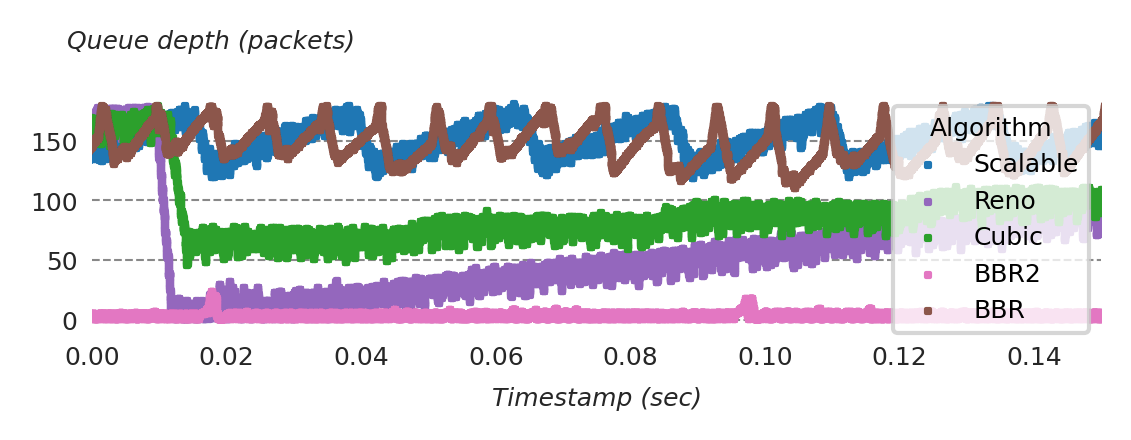

In [6]:
plt.figure(figsize=(width, 1/3*width), dpi=300)
plt.rcParams['font.family'] = 'DejaVu Sans'

colors = {
    'Scalable': 'C0',
    'Reno': 'C4',
    'Cubic': 'C2',
    'BBR': 'C5',
    'Vegas': 'C5',
    'BBR2': 'C6'
}

cubic['algorithm_readable'] = [a.upper() if 'bbr' in a else a.capitalize() for a in cubic.algorithm]

for alg,df in reversed(list(cubic.groupby('algorithm_readable'))):
    if alg == 'Vegas': continue
    plt.scatter(df.time, df.queue_depth_packets, label=alg, s=1, marker=',', color=colors[alg])
plt.xlabel("Timestamp (sec)")
plt.ylabel("Queue depth (packets)")
plorts.style_axis()
plt.axis(xmin=0, xmax=0.15)
plt.legend(loc='upper right', title='Algorithm')
plorts.savefig("../figures/traces/cubic.png")